# Neural Machine Translation

<sup> with inputs from https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html </sup>

General Reference: https://github.com/nyu-dl/NLP_DL_Lecture_Note/blob/master/lecture_note.pdf

### Install Google Translate API for Comparision

https://github.com/ssut/py-googletrans

In [1]:
getattr?

Docstring:
getattr(object, name[, default]) -> value

Get a named attribute from an object; getattr(x, 'y') is equivalent to x.y.
When a default argument is given, it is returned when the attribute doesn't
exist; without it, an exception is raised in that case.
Type:      builtin_function_or_method


In [2]:
!ls

1183-124566-0005.wav		label_train.json
1688-142285-0000.wav		main.ipynb
49 Blue-model.pt		model
AMMI_SR_lab1+2+3.ipynb		models.yml
ASR-SILERO.ipynb		MT .ipynb
ASR-Working-Copy1.ipynb		MT-model.pt
ASR-Working.ipynb		new
assets				NMT-ASR Transformers.ipynb
[Cascade] NMT-ASR.ipynb		NMT Transformer version_1.ipynb
data				NMT Transformer version_2.ipynb
Data Download(JW300) NMT.ipynb	others
DataGenerator[Cascade].ipynb	pyfiles
en2fr				raw.githubusercontent.com
en2ln				tensorflow
end2end-asr			test.wav
images				train.en
iwslt.pt			train.ln
jw300.en			tut5-model.pt
jw300.ln			Webscraping


In [3]:
# ! pip install googletrans

In [4]:
from googletrans import Translator
translator = Translator()

In [5]:
path_to_utils = 'pyfiles'

In [6]:
import os
import sys
sys.path.append(path_to_utils)

In [7]:
import global_variables
import nmt_dataset
import nnet_models_new

In [8]:
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

from functools import partial
import time
# from tqdm import tqdm_notebook as tqdm
import tqdm

In [9]:
base_saved_models_dir = '.'

### The Dataset

We will work with a English to French Dataset from https://www.manythings.org/anki/

### Setting Up the data

In [10]:
import os
source_language = "en"
target_language = "ln" # ln is the language code of lingala 
lc = False  # If True, lowercase the data.
seed = 42  # Random seed for shuffling.
tag = "baseline" # Give a unique name to your folder - this is to ensure you don't rewrite any models you've already submitted

os.environ["src"] = source_language # Sets them in bash as well, since we often use bash scripts
os.environ["tgt"] = target_language
os.environ["tag"] = tag

# No need to use gdrive since am using a gpu
# !mkdir -p "data/$src-$tgt"
os.environ["gdrive_path"] = "%s-%s" % (source_language, target_language) # saving directly on the vm

In [11]:
!echo $gdrive_path

en-ln


In [12]:
# Install opus-tools
# ! pip install opustools-pkg

In [15]:
# Downloading our corpus
# ! opus_read -d JW300 -s $src -t $tgt -wm moses -w train.$src train.$tgt -q

! opus_read -d JW300 -s $src -t $tgt -wm moses -w train.$src train.$tgt -q -dl ./data/

# TODO need to make this download directly in the /data folder 
# extract the corpus file
! gunzip JW300_latest_xml_$src-$tgt.xml.gz


Alignment file /proj/nlpl/data/OPUS/JW300/latest/xml/en-ln.xml.gz not found. The following files are available for downloading:

   5 MB https://object.pouta.csc.fi/OPUS-JW300/v1/xml/en-ln.xml.gz
 263 MB https://object.pouta.csc.fi/OPUS-JW300/v1/xml/en.zip
  60 MB https://object.pouta.csc.fi/OPUS-JW300/v1/xml/ln.zip

 328 MB Total size
./data/JW300_latest_xml_en-ln.xml.gz ... 100% of 5 MB
./data/JW300_latest_xml_en.zip ... 100% of 263 MB
./data/JW300_latest_xml_ln.zip ... 100% of 60 MB
gzip: JW300_latest_xml_en-ln.xml.gz: No such file or directory


In [14]:
# # Downloading our corpus
# ! opus_read -d JW300 -s $src -t $tgt -wm moses -w jw300.$src jw300.$tgt -q

# # extract the corpus file
# ! gunzip JW300_latest_xml_$src-$tgt.xml.gz

In [20]:
# Download the global test set.
! wget https://raw.githubusercontent.com/juliakreutzer/masakhane/master/jw300_utils/test/test.en-any.en
  
# And the specific test set for this language pair.
os.environ["trg"] = target_language 
os.environ["src"] = source_language 

! wget https://raw.githubusercontent.com/juliakreutzer/masakhane/master/jw300_utils/test/test.en-$trg.en 
! mv test.en-$trg.en data/test.en
! wget https://raw.githubusercontent.com/juliakreutzer/masakhane/master/jw300_utils/test/test.en-$trg.$trg 
! mv test.en-$trg.$trg data/test.$trg

--2020-11-27 22:08:03--  https://raw.githubusercontent.com/juliakreutzer/masakhane/master/jw300_utils/test/test.en-any.en
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 277791 (271K) [text/plain]
Saving to: ‘test.en-any.en’

test.en-any.en      100%[===================>] 271.28K  --.-KB/s    in 0.02s   

2020-11-27 22:08:04 (15.8 MB/s) - ‘test.en-any.en’ saved [277791/277791]

--2020-11-27 22:08:04--  https://raw.githubusercontent.com/juliakreutzer/masakhane/master/jw300_utils/test/test.en-ln.en
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Leng

In [21]:
main_data_path = './data/'

In [22]:
source_name = 'en'
target_name = 'ln'

path_to_train_data = {'source':main_data_path+'train.'+source_name, 
                      'target':main_data_path+'train.'+target_name}
path_to_val_data = {'source': main_data_path+'valid.'+source_name, 
                      'target':main_data_path+'valid.'+target_name}

In [25]:
saved_models_dir = os.path.join(base_saved_models_dir, source_name+'2'+target_name)

In [26]:
## See first 5 records
! head -5 'data/train.'$source_name

Who Wants to Be a Millionaire ?
THE answer seems to be : almost everybody .
And the easiest way to become one ​ — according to popular opinion — ​ is by striking it rich in a lottery or a soccer pool . *
Pandering to prevailing taste ​ — and wanting the extra income that lotteries generate — ​ governments from Moscow to Madrid , from Manila to Mexico City , sponsor State lotteries that offer prizes as high as a hundred million dollars .
A few people do become millionaires .


In [27]:
! head -5 'data/train.'$target_name

Nani alingi kozala milionere ?
EYANO emonani lokola ete , wana ezali mposa ya moto na moto to pene na bato nyonso .
Nzokande , na makanisi ya bato , nzela ya pɛtɛɛ mpo na kozwa yango ezali kolónga na loterie to na momekano ya kosakola liboso équipe ya ndembo oyo ekolónga .
Kolamusáká mposa ya bato mingi ​ — mpe koluláká kozwa misolo oyo Leta akozwa likoló ​ — kolongwa Moscou kino Madrid , kolongwa Manille kino Mexico , baguvernema bazali kopesa lisungi na loterie esalemi na Leta , kati na yango balóngi bakoki kozwa nkámá mingi ya bamilió ya badolare .
Mwa babɛti na yango bazali mpenza kokóma bamilionere .


### Processing and making PyTorch Dataset

We have to make it a pair - (source, target) sentence pair. For this, we have to read the file and parse it accordingly. We might have to take care of some details there, like making sure that we strip off any non-required special characters or extra space. All those boring details aside (which you can see in dataset_helper.py) what are the other things we have to do?

We have to make a vocabulary and tokenize like we have been doing. Here, we are writing a Language Class, to take care of this for you. Once we have done all this and tokenized, we write a pytorch dataset object to help as handle this efficiently during training

In [16]:
saved_language_model_dir = os.path.join(saved_models_dir, 'lang_obj')

In [17]:
dataset_dict = {'train': nmt_dataset.LanguagePair(source_name = source_name, target_name=target_name, 
                    filepath = path_to_train_data, 
                    lang_obj_path = saved_language_model_dir,
                     minimum_count = 1), 

                'val': nmt_dataset.LanguagePair(source_name = source_name, target_name=target_name, 
                    filepath = path_to_val_data, 
                    lang_obj_path = saved_language_model_dir,
                    minimum_count = 1)}

The LanguagePair object we built has a DataFrame underneath. We see the first 5 rows of the dataframe below:

In [18]:
dataset_dict['train'].main_df.iloc[:5]

,source_data,target_data,source_tokenized,source_len,target_tokenized,target_len,source_indized,target_indized
0,Who Wants to Be a Millionaire ?,Nani alingi kozala milionere ?,"[who, wants, to, be, a, millionaire, ?]",8,"[nani, alingi, kozala, milionere, ?]",6,"[1, 1, 22, 69, 102, 1, 1, 3]","[1, 1, 116, 1, 1, 3]"
1,THE answer seems to be : almost everybody .,"EYANO emonani lokola ete , wana ezali mposa ya...","[the, answer, seems, to, be, :, almost, everyb...",10,"[eyano, emonani, lokola, ete, ,, wana, ezali, ...",19,"[6, 1, 1, 22, 69, 1, 1, 1, 1, 3]","[1, 1, 1, 106, 1, 1, 1, 1, 5, 1, 14, 1, 1, 1, ..."
2,And the easiest way to become one ​ — accordin...,"Nzokande , na makanisi ya bato , nzela ya pɛtɛ...","[and, the, easiest, way, to, become, one, ​, —...",30,"[nzokande, ,, na, makanisi, ya, bato, ,, nzela...",31,"[53, 6, 1, 1, 22, 1, 12, 1, 1, 1, 22, 1, 1, 1,...","[1, 1, 14, 1, 5, 1, 1, 1, 5, 1, 75, 14, 1, 32,..."
3,Pandering to prevailing taste ​ — and wanting ...,Kolamusáká mposa ya bato mingi ​ — mpe kolulák...,"[pandering, to, prevailing, taste, ​, —, and, ...",43,"[kolamusáká, mposa, ya, bato, mingi, ​, —, mpe...",51,"[1, 22, 1, 1, 1, 1, 53, 1, 6, 1, 1, 1, 1, 1, 1...","[1, 1, 5, 1, 1, 1, 1, 31, 1, 1, 1, 12, 1, 1, 1..."
4,A few people do become millionaires .,Mwa babɛti na yango bazali mpenza kokóma bamil...,"[a, few, people, do, become, millionaires, .]",8,"[mwa, babɛti, na, yango, bazali, mpenza, kokóm...",10,"[102, 1, 1, 82, 1, 1, 1, 3]","[1, 1, 14, 32, 1, 1, 1, 1, 1, 3]"


In [20]:
dataset_dict['train'].main_df.tail()

,source_data,target_data,source_tokenized,source_len,target_tokenized,target_len,source_indized,target_indized
601109,"Rather , because of our faith in God , we have...","Kasi , lokola tondimelaka Nzambe , tosepelaka ...","[rather, ,, because, of, our, faith, in, god, ...",23,"[kasi, ,, lokola, tondimelaka, nzambe, ,, tose...",20,"[1, 1, 1, 8, 1, 1, 14, 1, 1, 1, 60, 1, 1, 1, 3...","[65, 1, 1, 1, 1, 1, 1, 1, 14, 1, 14, 1, 14, 35..."
601110,Thousands of people around the world have also...,Ebele ya bato na mokili mobimba babandá mpe ko...,"[thousands, of, people, around, the, world, ha...",25,"[ebele, ya, bato, na, mokili, mobimba, babandá...",23,"[1, 8, 1, 1, 6, 1, 60, 34, 1, 22, 1, 6, 1, 53,...","[1, 5, 1, 14, 16, 1, 1, 31, 1, 1, 31, 1, 1, 12..."
601111,This has motivated many of them to change thei...,Yango esalisaki mingi na bango bábongola bomoi...,"[this, has, motivated, many, of, them, to, cha...",23,"[yango, esalisaki, mingi, na, bango, bábongola...",18,"[67, 1, 1, 1, 8, 1, 22, 1, 1, 1, 8, 1, 1, 22, ...","[32, 1, 1, 14, 96, 1, 1, 14, 96, 1, 1, 1, 1, 3..."
601112,The way they are being affected is clear proof...,Ndenge oyo bazali kobongwana emonisi polele et...,"[the, way, they, are, being, affected, is, cle...",23,"[ndenge, oyo, bazali, kobongwana, emonisi, pol...",21,"[6, 1, 1, 5, 1, 1, 110, 1, 1, 1, 1, 6, 19, 8, ...","[1, 12, 1, 1, 1, 1, 106, 1, 18, 5, 1, 1, 14, 1..."
601113,What God has revealed in the Bible about his p...,Makambo oyo Nzambe amonisá na Biblia mpo na mo...,"[what, god, has, revealed, in, the, bible, abo...",28,"[makambo, oyo, nzambe, amonisá, na, biblia, mp...",29,"[1, 1, 1, 1, 14, 6, 1, 1, 31, 1, 1, 1, 1, 1, 1...","[1, 12, 1, 1, 14, 1, 75, 14, 1, 14, 35, 1, 1, ..."


### vocabulary sizes and sentence lengths

In [19]:
### vocabulary sizes
print('source vocab: ', dataset_dict['train'].source_lang_obj.n_words , 
      'target vocab: ', dataset_dict['train'].target_lang_obj.n_words)

source vocab:  115 target vocab:  126


In [23]:
### vocabulary sizes
print('source vocab: ', dataset_dict['train'].source_lang_obj.n_words , 
      'target vocab: ', dataset_dict['train'].target_lang_obj.n_words)

source vocab:  60342 target vocab:  67974


In [24]:
### vocabulary sizes
print('max len: ', dataset_dict['train'].main_df['source_len'].max(), 
      'min len: ', dataset_dict['train'].main_df['source_len'].min() )

max len:  3780 min len:  2


In [25]:
dataset_dict['train'].main_df['source_len'].quantile([0.5, 0.75, 0.9, 0.95, 0.99, 0.999, 0.9999])

0.5000     17.0
0.7500     25.0
0.9000     33.0
0.9500     39.0
0.9900     54.0
0.9990     77.0
0.9999    111.0
Name: source_len, dtype: float64

51 looks like a very long sentence and at the $99.99$th percentile is 32. We probably don't want that much. How do we get rid of rest of the words or clip sentence at some MAX LEN? We can use the collate function of pytorch that we had seen earlier to do this. 

In [26]:
MAX_LEN = int(dataset_dict['train'].main_df['source_len'].quantile(0.9999))
batchSize = 64

In [27]:
dataloader_dict = {'train': DataLoader(dataset_dict['train'], batch_size = batchSize, 
                            collate_fn = partial(nmt_dataset.vocab_collate_func, MAX_LEN=MAX_LEN),
                            shuffle = True, num_workers=0), 
                    'val': DataLoader(dataset_dict['val'], batch_size = batchSize, 
                            collate_fn = partial(nmt_dataset.vocab_collate_func, MAX_LEN=MAX_LEN),
                            shuffle = True, num_workers=0) }

The Seq2Seq Model
=================

A Recurrent Neural Network, or RNN, is a network that operates on a
sequence and uses its own output as input for subsequent steps.

A `Sequence to Sequence network <http://arxiv.org/abs/1409.3215>`__, or
seq2seq network, or `Encoder Decoder
network <https://arxiv.org/pdf/1406.1078v3.pdf>`__, is a model
consisting of usually of two RNNs called the encoder and decoder. The encoder reads
an input sequence and outputs a single vector, and the decoder reads
that vector to produce an output sequence. Essentially, all we need is some mechanism to read the source sentence and create an encoding and some mechanism to read the encoding and decode it to the target language. 

Unlike sequence prediction with a single RNN, where every input
corresponds to an output, the **seq2seq model frees us from sequence
length and order**, which makes it ideal for translation between two
languages.

Consider the sentence "I am not the
black cat" → "Je ne suis pas le chat noir". Most of the words in the input sentence have a direct
translation in the output sentence, but are in slightly different
orders, e.g. "chat noir" and "black cat". Because of the "ne/pas"
construction there is also one more word in the input sentence. It would
be difficult to produce a correct translation directly from the sequence
of input words.

**With a seq2seq model the encoder creates a single vector which, in the ideal case, encodes the "meaning" of the input sequence into a single vector** - a single point in some N dimensional space of sentences.




### Concepts:
1. NMT as a conditional language modelling
2. Encoder
3. Decoding during evaluation - step by step (see code)
4. **Teaching Forcing (see code) and train step**
5. How do we evaluate the quality of translation? BLEU Score

The Encoder
-----------

**The encoder is anything which takes in a sentence and gives us a representation for the sentence.** 

Usually, the encoder of a seq2seq network is a RNN that outputs some value for
every word from the input sentence. For every input word the encoder
outputs a vector and a hidden state, and uses the hidden state for the
next input word.

However, we will first start with a BoW encoder and then move on to RNN based encoders

In [28]:
### configuration
source_lang_obj = dataset_dict['train'].source_lang_obj
target_lang_obj = dataset_dict['train'].target_lang_obj

source_vocab = dataset_dict['train'].source_lang_obj.n_words;
target_vocab = dataset_dict['train'].target_lang_obj.n_words;
hidden_size = 512
rnn_layers = 1
lr = 0.25;
longest_label = 32;
gradient_clip = 0.3;
use_cuda = True

num_epochs = 10

### BagOfWords Encoder

In [29]:
encoder_bow = nnet_models_new.BagOfWords(input_size = source_vocab,
                                    hidden_size = hidden_size, 
                                    nlayers=4, 
                                    reduce = "sum")

In [30]:
print(encoder_bow)

BagOfWords(
  (embedding): Embedding(60342, 512, padding_idx=0)
  (layers): ModuleList(
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=512, out_features=512, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.1, inplace=False)
    (9): Linear(in_features=512, out_features=512, bias=True)
  )
)


The Decoder
--------------------


The decoder is another RNN that takes the encoder output vector(s) and outputs a sequence of words to create the translation.

Decoder w/o Attention
------------------------
In the simplest seq2seq decoder we use only last output of the encoder. This **last output is sometimes called the context vector as it encodes context from the entire sequence**. This context vector is used as the initial hidden state of the decoder.

At every step of decoding, the decoder is given an input token and hidden state. The initial input token is the start-of-string <SOS> token, and the first hidden state is the context vector (the encoder's last hidden state).

In [31]:
decoder_bow = nnet_models_new.DecoderRNN(target_vocab, hidden_size, rnn_layers)

In [32]:
print(decoder_bow)

DecoderRNN(
  (embedding): Embedding(67974, 512)
  (gru): GRU(512, 512, batch_first=True)
  (out): Linear(in_features=512, out_features=67974, bias=True)
  (softmax): LogSoftmax()
)


In [33]:
nmt_bow = nnet_models_new.seq2seq(encoder_bow, decoder_bow,
                              lr = 1e-2, 
                              use_cuda = use_cuda, 
                              hiddensize = hidden_size, 
                              numlayers = hidden_size, 
                              target_lang=dataset_dict['train'].target_lang_obj,
                              longest_label = longest_label,
                              clip = gradient_clip)

In [34]:
nmt_bow

seq2seq(
  (encoder): BagOfWords(
    (embedding): Embedding(60342, 512, padding_idx=0)
    (layers): ModuleList(
      (0): Linear(in_features=512, out_features=512, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.1, inplace=False)
      (3): Linear(in_features=512, out_features=512, bias=True)
      (4): ReLU()
      (5): Dropout(p=0.1, inplace=False)
      (6): Linear(in_features=512, out_features=512, bias=True)
      (7): ReLU()
      (8): Dropout(p=0.1, inplace=False)
      (9): Linear(in_features=512, out_features=512, bias=True)
    )
  )
  (decoder): DecoderRNN(
    (embedding): Embedding(67974, 512)
    (gru): GRU(512, 512, batch_first=True)
    (out): Linear(in_features=512, out_features=67974, bias=True)
    (softmax): LogSoftmax()
  )
  (criterion): NLLLoss()
)

### Training Loop

In [35]:
def get_full_filepath(path, enc_type):
    filename = 'nmt_enc_'+enc_type+'_dec_rnn.pth'
    return os.path.join(path, filename)

In [36]:
def save_models(nmt_model, path, enc_type):
    if not os.path.exists(path):
            os.makedirs(path)
    filename = 'nmt_enc_'+enc_type+'_dec_rnn.pth'
    torch.save(nmt_model, os.path.join(path, filename))
   

In [37]:
def train_model(dataloader, nmt, num_epochs=50, val_every=1, saved_model_path = '.', enc_type ='rnn'):

    best_bleu = -1;
    for epoch in range(num_epochs):

        start = time.time()
        running_loss = 0

        print('Epoch: [{}/{}]'.format(epoch, num_epochs));
        
        for i, data in tqdm.tqdm_notebook(enumerate(dataloader['train']), total=len(dataloader['train'])):  
            _, curr_loss = nmt.train_step(data);
            running_loss += curr_loss

        epoch_loss = running_loss / len(dataloader['train']) 
        
        print("epoch {} loss = {}, time = {}".format(epoch, epoch_loss,
                                                        time.time() - start))
        sys.stdout.flush()
   
        if epoch%val_every == 0:
            val_bleu_score = nmt.get_bleu_score(dataloader['val']);
            print('validation bleu: ', val_bleu_score)
            sys.stdout.flush()
            
            nmt.scheduler_step(val_bleu_score);
            
            if val_bleu_score > best_bleu:
                best_bleu = val_bleu_score
                
                print('Saving Model ...')        
                save_models(nmt, saved_model_path, enc_type);
                print('*****************************************************')
                print('best record: [epoch %d], [val bleu %.5f]' % (epoch, val_bleu_score))
                print('*****************************************************')

        print('='*50)

    print("Training completed. Best BLEU is {}".format(best_bleu))

    

### Training Bow Encoder GRU Decoder Model

In [38]:
train_again = False
modelname = 'bow_model'

device = torch.device('cuda') if use_cuda and torch.cuda.is_available() else torch.device('cpu');
if os.path.exists(get_full_filepath(saved_models_dir, modelname)) and (not train_again):
# if (not train_again):
    nmt_bow = torch.load(get_full_filepath(saved_models_dir, modelname))
    print('Model loaded')
else:
    train_model(dataloader_dict, nmt_bow, 
                          num_epochs = num_epochs, 
                          saved_model_path = saved_models_dir, 
                          enc_type = 'bow_test')

Epoch: [0/10]


/home/aims/anaconda3/envs/aims/lib/python3.6/site-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()



epoch 0 loss = 1.5363090340975358, time = 3682.069237470627
validation bleu:  10.074759547933018
Saving Model ...
*****************************************************
best record: [epoch 0], [val bleu 10.07476]
*****************************************************
Epoch: [1/10]



epoch 1 loss = 1.289799224142654, time = 3628.751379966736
validation bleu:  13.313869508361837
Saving Model ...
*****************************************************
best record: [epoch 1], [val bleu 13.31387]
*****************************************************
Epoch: [2/10]



epoch 2 loss = 1.2222007019679544, time = 3612.731211900711
validation bleu:  13.013331536741825
Epoch     3: reducing learning rate of group 0 to 1.0000e-03.
Epoch: [3/10]



epoch 3 loss = 1.1603181346708138, time = 3643.5859167575836
validation bleu:  15.570808019793745
Saving Model ...
*****************************************************
best record: [epoch 3], [val bleu 15.57081]
*****************************************************
Epoch: [4/10]



epoch 4 loss = 1.149072199614019, time = 3658.458485841751
validation bleu:  16.259630358134924
Saving Model ...
*****************************************************
best record: [epoch 4], [val bleu 16.25963]
*****************************************************
Epoch: [5/10]



epoch 5 loss = 1.144218705284368, time = 3597.6756448745728
validation bleu:  16.39346308802514
Saving Model ...
*****************************************************
best record: [epoch 5], [val bleu 16.39346]
*****************************************************
Epoch: [6/10]



epoch 6 loss = 1.1378907518201256, time = 3578.883498430252
validation bleu:  16.281298622369054
Epoch     7: reducing learning rate of group 0 to 1.0000e-04.
Epoch: [7/10]



epoch 7 loss = 1.1309015829009486, time = 3628.325040578842
validation bleu:  16.556682906950545
Saving Model ...
*****************************************************
best record: [epoch 7], [val bleu 16.55668]
*****************************************************
Epoch: [8/10]



epoch 8 loss = 1.1289743109600552, time = 3621.696895122528
validation bleu:  16.749525680185755
Saving Model ...
*****************************************************
best record: [epoch 8], [val bleu 16.74953]
*****************************************************
Epoch: [9/10]



epoch 9 loss = 1.1300182155392424, time = 3585.7700893878937
validation bleu:  16.61571392871028
Training completed. Best BLEU is 16.749525680185755


### Check Performance

In [41]:
print(nmt_bow.get_bleu_score(dataloader_dict['val']))

16.61571392871028


## Interacting with the system

In [43]:
from collections import namedtuple
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import copy
%matplotlib inline


def get_binned_bl_score(nmt_model, val_dataset):
    
    len_threshold = np.arange(0, 31, 5)
    bin_bl_score = np.zeros(len(len_threshold));
    
    for i in tqdm.tqdm_notebook( range(1, len(len_threshold)), total = len(len_threshold)-1):
        min_len = len_threshold[i-1]
        max_len = len_threshold[i]
        
        temp_dataset = copy.deepcopy(val_dataset);
        temp_dataset.main_df = temp_dataset.main_df[(temp_dataset.main_df['source_len'] > min_len) & (temp_dataset.main_df['source_len'] <= max_len)];
        temp_loader = DataLoader(temp_dataset, batch_size = batchSize, 
                            collate_fn = partial(nmt_dataset.vocab_collate_func, MAX_LEN=100),
                            shuffle = True, num_workers=0)
        
        bin_bl_score[i] = nmt_model.get_bleu_score(temp_loader);
        
    
    len_threshold = len_threshold[1:]
    bin_bl_score = bin_bl_score[1:]
    
    plt.plot(len_threshold, bin_bl_score, 'x-')
    plt.ylim(0, np.max(bin_bl_score)+1)
    plt.xlabel('len')
    plt.ylabel('bl score')
    
    return len_threshold, bin_bl_score
    
        
        
    
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions, cmap='bone', aspect='auto')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       [global_variables.EOS_TOKEN], rotation=90)
    ax.set_yticklabels([''] + output_words.split(' ')+
                       [global_variables.EOS_TOKEN]);

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

def get_encoded_batch(sentence, lang_obj, use_cuda):
    """ accepts only bsz = 1.
        input: one sentence as a string
        output: named tuple with vector and length"""
    
    sentence = sentence + ' ' + global_variables.EOS_TOKEN;
    tensor = source_lang_obj.txt2vec(sentence).unsqueeze(0)
    
    device = torch.device('cuda') if use_cuda and torch.cuda.is_available() else torch.device('cpu');
    
    named_returntuple = namedtuple('namedtuple', ['text_vecs', 'text_lens', 'label_vecs', 'label_lens', 'use_packed'])
    return_tuple = named_returntuple( tensor.to(device), 
                                     torch.from_numpy(np.array([tensor.shape[-1]])).to(device),
                                     None,
                                     None,
                                     False );

    return return_tuple

def get_translation(nmt_model, sentence, lang_obj, use_cuda):
    print('souce: ', sentence)
    batch = get_encoded_batch(sentence, lang_obj, use_cuda);
    
    prediction, attn_scores_list = nmt_model.eval_step(batch, return_attn = True);
    prediction = prediction[0];
    print('prediction: ', prediction)
#     print('GT on sentence (src->tgt): ', translator.translate(sentence, 
#                                                      src = source_name,
#                                                      dest = target_name).text)
#     print('GT on prediction (tgt->src): ', translator.translate(prediction, 
#                                                      src = target_name,
#                                                      dest = source_name).text)

    if attn_scores_list[0] is not None:
        if attn_scores_list[0][0] is not None:
            attn_matrix = [x[0].data.cpu().numpy() for x in attn_scores_list];
            attn_matrix = np.stack(attn_matrix)[:,:, 0]
            showAttention(sentence, prediction, attn_matrix)

In [49]:
get_translation(nmt_bow, 'How are you ?', source_lang_obj, use_cuda)

souce:  How are you ?
prediction:  yo mpe ndenge nini ?


In [50]:
get_translation(nmt_bow, 'are hello ? how you', source_lang_obj, use_cuda)

souce:  are hello ? how you
prediction:  ozali na yango ?


## RNN Encoder

In [51]:
encoder_rnn = nnet_models_new.EncoderRNN(source_vocab, hidden_size, rnn_layers)

In [52]:
print(encoder_rnn)

EncoderRNN(
  (embedding): Embedding(60342, 512, padding_idx=0)
  (gru): GRU(512, 512, batch_first=True)
)


In [53]:
decoder_rnn = nnet_models_new.DecoderRNN(target_vocab, hidden_size, rnn_layers)

In [54]:
print(decoder_rnn)

DecoderRNN(
  (embedding): Embedding(67974, 512)
  (gru): GRU(512, 512, batch_first=True)
  (out): Linear(in_features=512, out_features=67974, bias=True)
  (softmax): LogSoftmax()
)


In [55]:
nmt_rnn = nnet_models_new.seq2seq(encoder_rnn, decoder_rnn,
                              lr = lr, 
                              use_cuda = use_cuda, 
                              hiddensize = hidden_size, 
                              numlayers = hidden_size, 
                              target_lang=dataset_dict['train'].target_lang_obj,
                              longest_label = longest_label,
                              clip = gradient_clip)

In [ ]:
train_again = False
modelname = 'rnn_model'
if os.path.exists(get_full_filepath(saved_models_dir, modelname)) and (not train_again):
    nmt_rnn = torch.load(get_full_filepath(saved_models_dir, modelname))
else:
    train_model(dataloader_dict, nmt_rnn, 
                      num_epochs = num_epochs, 
                      saved_model_path = saved_models_dir, 
                      enc_type = 'rnn_test')

Epoch: [0/10]


/home/aims/anaconda3/envs/aims/lib/python3.6/site-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()



epoch 0 loss = 1.2880906560114953, time = 3688.207519054413
validation bleu:  18.51976501025157
Saving Model ...
*****************************************************
best record: [epoch 0], [val bleu 18.51977]
*****************************************************
Epoch: [1/10]



epoch 1 loss = 1.0706906775327631, time = 3665.2570157051086
validation bleu:  19.45254189488355
Saving Model ...
*****************************************************
best record: [epoch 1], [val bleu 19.45254]
*****************************************************
Epoch: [2/10]



epoch 2 loss = 1.0029336581909698, time = 3659.775911092758
validation bleu:  21.692237481960152
Saving Model ...
*****************************************************
best record: [epoch 2], [val bleu 21.69224]
*****************************************************
Epoch: [3/10]



epoch 3 loss = 0.9637230311658521, time = 3644.792008161545
validation bleu:  22.223842743308218
Saving Model ...
*****************************************************
best record: [epoch 3], [val bleu 22.22384]
*****************************************************
Epoch: [4/10]



epoch 4 loss = 0.9367893118563158, time = 3637.0132372379303
validation bleu:  22.24881398986678
Saving Model ...
*****************************************************
best record: [epoch 4], [val bleu 22.24881]
*****************************************************
Epoch: [5/10]


### Check Performance

In [ ]:
print(nmt_rnn.get_bleu_score(dataloader_dict['val']))

### Interacting with system

In [ ]:
get_translation(nmt_rnn, 'how are you ?', source_lang_obj, use_cuda)

In [ ]:
get_translation(nmt_rnn, 'are hello ? how you', source_lang_obj, use_cuda)

In [ ]:
get_translation(nmt_rnn, 'i know that the last thing you want to do is help me .', source_lang_obj, use_cuda)

In [ ]:
rnn_len_threshold, rnn_bin_bl = get_binned_bl_score(nmt_rnn, dataset_dict['val'])

We work with a small training data and hence you see this drop in BLEU score for sentences of shorter length. We don't have enough data points with small sentence length

## RNN Encoder + Source Side Attention

### Concepts:
1. Context Vector which gives additional information from source side for decoding the next token. 
2. Fit context vector into decoding framework: <br>
    a) Initiaze with 0 <br>
    b) input to RNN is the concatenation of the input token and context vector <br>
    c) output token decoded from context vector calculated from the hidden of previous timestep; i.e, context vector for the next timestep is used for decoding the current output
3. Calculating the context vector. Explain attention module: <br>
    a) hidden transformed to encoder hidden dimension using linear layer. This is your query vector. <br> 
    b) Value and Key vectors are the encoder outputs. <br>
    c) Dot product. Raw Score. Softmax. Linear Combination. <br>
    d) contactenated the linear combination vector with the input hidden from decoder. Pass it through a linear layer to project it back to decoder hidden dimension followed by a `tanh`.  

    
    

In [ ]:
encoder_attention = True
self_attention = False

In [ ]:
encoder_encoderattn = nnet_models_new.EncoderRNN(source_vocab, hidden_size, 1)

In [ ]:
decoder_encoderattn = nnet_models_new.Decoder_SelfAttn(output_size=target_vocab,
                                 hidden_size=hidden_size, 
                                 encoder_attention = encoder_attention,
                                 self_attention = self_attention)

In [ ]:
nmt_encoderattn = nnet_models_new.seq2seq(encoder_encoderattn, decoder_encoderattn,
                              lr = lr, 
                              use_cuda = use_cuda, 
                              hiddensize = hidden_size, 
                              numlayers = hidden_size, 
                              target_lang=dataset_dict['train'].target_lang_obj,
                              longest_label = longest_label,
                              clip = gradient_clip)

In [ ]:
train_again = False
modelname = 'encoderattn_model'
if os.path.exists(get_full_filepath(saved_models_dir, modelname)) and (not train_again):
    nmt_encoderattn = torch.load(get_full_filepath(saved_models_dir, modelname))
else:
    train_model(dataloader_dict, nmt_encoderattn, 
                      num_epochs = num_epochs, 
                      saved_model_path = saved_models_dir, 
                      enc_type = 'encoderattn_test')

### Check Performance

In [60]:
print(nmt_encoderattn.get_bleu_score(dataloader_dict['val']))

38.68336012941632


### BLEU vs Sentence Length

/home/aims/anaconda3/envs/aims/lib/python3.7/site-packages/ipykernel_launcher.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


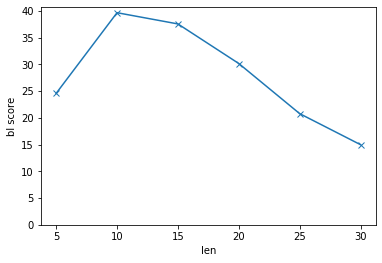

In [61]:
attn_len_threshold, attn_bin_bl = get_binned_bl_score(nmt_encoderattn, dataset_dict['val'])

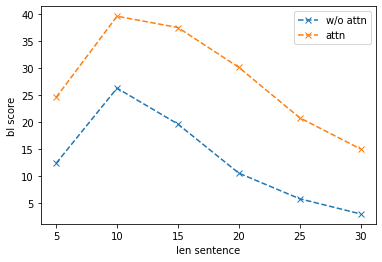

In [62]:
plt.plot(rnn_len_threshold, rnn_bin_bl, '--x', label = 'w/o attn')
plt.plot(attn_len_threshold, attn_bin_bl, '--x', label = 'attn')
plt.xlabel('len sentence')
plt.ylabel('bl score')
plt.legend()

### Interacting with system

souce:  how are you ?
prediction:  comment allez vous ?
GT on sentence (src->tgt):  Comment allez-vous ?
GT on prediction (tgt->src):  how are you ?


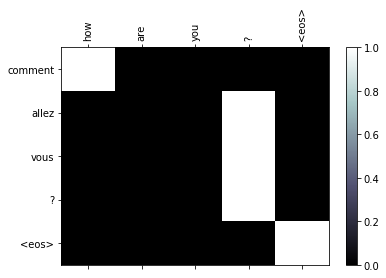

In [63]:
get_translation(nmt_encoderattn, 'how are you ?', source_lang_obj, use_cuda)

souce:  she knows better than to argue with him .
prediction:  elle sait mieux que de ne pas le disputer avec lui .
GT on sentence (src->tgt):  elle sait mieux que de discuter avec lui.
GT on prediction (tgt->src):  she knows better than not to argue with him.


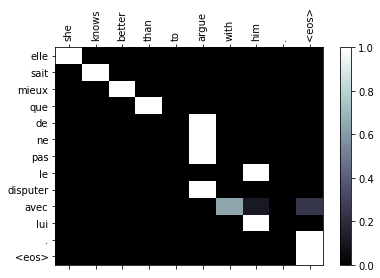

In [64]:
get_translation(nmt_encoderattn, 'she knows better than to argue with him .', source_lang_obj, use_cuda)

souce:  she s five years younger than me .
prediction:  elle a cinq ans de moins que moi .
GT on sentence (src->tgt):  elle est cinq ans plus jeune que moi.
GT on prediction (tgt->src):  She was five years younger than me.


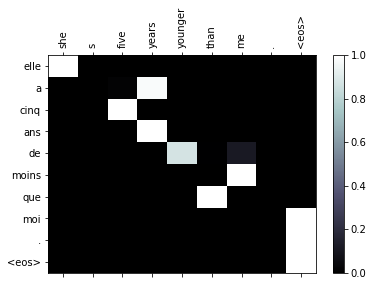

In [65]:
get_translation(nmt_encoderattn, 'she s five years younger than me .', source_lang_obj, use_cuda)

souce:  i know that the last thing you want to do is help me .
prediction:  je sais que la derniere chose que tu veuilles faire est de m aider .
GT on sentence (src->tgt):  Je sais que la dernière chose que vous voulez faire est de me d'aide.
GT on prediction (tgt->src):  I know the last thing you want to do is help me.


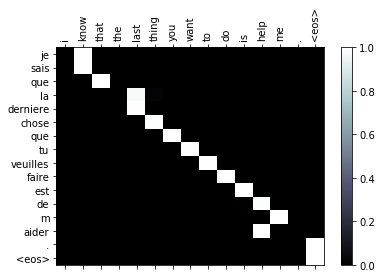

In [66]:
get_translation(nmt_encoderattn, 'i know that the last thing you want to do is help me .', source_lang_obj, use_cuda)